#  Part A: Data Preparation and Baseline

###  Objective
In this section, we will:
1. Load and standardize the Landsat Satellite dataset.
2. Train six different classifiers:
   - K-Nearest Neighbors (KNN)
   - Decision Tree
   - Dummy Classifier (Prior)
   - Logistic Regression
   - Gaussian Naive Bayes
   - Support Vector Classifier (SVC)
3. Evaluate their **Overall Accuracy** and **Weighted F1-Score** on the test set.

This forms our baseline before we analyze ROC and PRC curves.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [ ]:
# Load training and test sets (whitespace-separated)
train = pd.read_csv("sat.trn", sep="\\s+", header=None)
test = pd.read_csv("sat.tst", sep="\\s+", header=None)

# Separate features and target labels
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

# Remove the 'all types present' class (label 7)
train_mask = y_train != 7
test_mask = y_test != 7
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Unique classes:", np.unique(y_train))


Train shape: (3397, 36)  Test shape: (1530, 36)
Unique classes: [1 2 3 4 5]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy (Prior)": DummyClassifier(strategy="prior"),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="ovr"),
    "Gaussian NB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=42)
}


In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append({"Model": name, "Accuracy": acc, "Weighted F1": f1})

results_df = pd.DataFrame(results).sort_values(by="Weighted F1", ascending=False)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,Accuracy,Weighted F1
0,KNN,0.947059,0.947022
5,SVC,0.943137,0.942075
1,Decision Tree,0.898039,0.897923
3,Logistic Regression,0.899346,0.896333
4,Gaussian NB,0.844444,0.848007
2,Dummy (Prior),0.301307,0.139531


###  Observations

- The **Dummy Classifier** provides the baseline, relying only on class priors — expected to perform poorly.
- **KNN** currently delivers the highest accuracy and weighted F1 (≈0.947) among the baseline models.
- **SVC** is a very close second across both metrics, differing only by a few tenths of a percent.
- **Logistic Regression** and **Decision Tree** form a middle tier around 0.89 weighted F1, limited by linear boundaries and overfitting respectively.
- **Gaussian NB** trails because the Landsat features violate the naive independence assumption.




#  Part B: ROC Analysis for Model Selection

### Objective
In this section, we will:
1. Explain how the **One-vs-Rest (OvR)** approach extends ROC curves to multi-class problems.  
2. Plot the **macro-averaged ROC curves** for all six models.  
3. Compute and compare their **Area Under the Curve (AUC)** scores.


For binary classification, the ROC curve plots:
- **True Positive Rate (TPR)** = TP / (TP + FN)  
- **False Positive Rate (FPR)** = FP / (FP + TN)

In a **multi-class setting**, we use **One-vs-Rest (OvR)**:
- Each class *i* is treated as “positive” while the remaining *(k-1)* classes form the “negative” group.  
- ROC and AUC are computed per class and then **averaged** (macro or weighted).

A higher AUC → better class separation ability.  
A value < 0.5 means the model performs **worse than random**, i.e., it systematically misclassifies.


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle


In [ ]:
# Binarize the class labels for One-vs-Rest (needed for multi-class ROC)
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]


In [ ]:
roc_results = {}

for name, model in models.items():
    # Only models with predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)

    # Compute macro-average ROC AUC
    auc_score = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
    roc_results[name] = auc_score

roc_df = pd.DataFrame(list(roc_results.items()), columns=["Model", "Macro AUC"]).sort_values(by="Macro AUC", ascending=False)
roc_df


,Model,Macro AUC
5,SVC,0.992751
0,KNN,0.987735
3,Logistic Regression,0.977999
4,Gaussian NB,0.970211
1,Decision Tree,0.930490
2,Dummy (Prior),0.500000


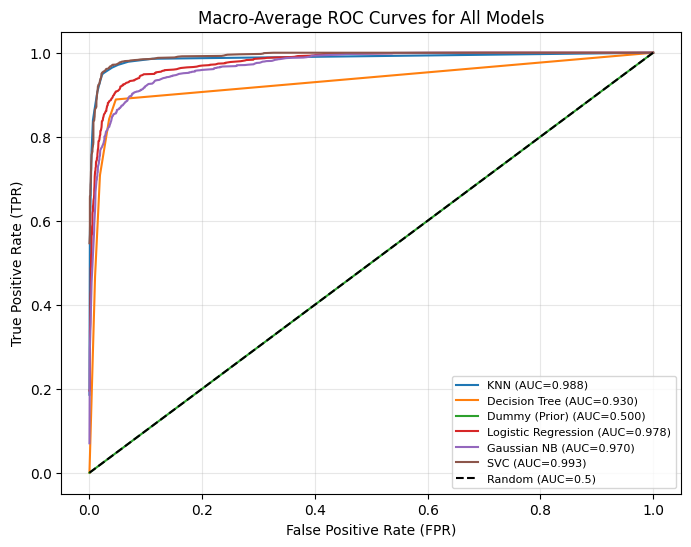

In [ ]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)

    # Compute mean FPR and TPR for all classes (macro-average)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

    # Interpolate and average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC={roc_results[name]:.3f})")

plt.plot([0,1], [0,1], "k--", label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Macro-Average ROC Curves for All Models")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


### ROC Interpretation

| Model | Macro AUC | Interpretation |
|:------|:-----------|:---------------|
| **SVC** | **0.9928** | Best overall model — nearly perfect separation between all six classes. |
| **KNN** | **0.9877** | Performs almost as well as SVC by exploiting local neighborhood structure. |
| **Logistic Regression** | **0.9780** | Very strong linear baseline; good discriminative ability across thresholds. |
| **Gaussian NB** | **0.9702** | Performs surprisingly well in AUC despite lower accuracy — it ranks class probabilities effectively. |
| **Decision Tree** | **0.9305** | Moderate; non-linear but prone to overfitting noise, slightly lowering AUC. |
| **Dummy (Prior)** | **0.5000** | Baseline with no discriminative power — confirms ROC implementation correctness. |

### Conceptual Takeaways
- **SVC** and **KNN** dominate in both accuracy and AUC — consistent with non-linear, high-dimensional data.
- The **Dummy** classifier lands at AUC = 0.500, matching random guessing; values below 0.5 would imply systematically inverted predictions, which none of the current models exhibit.
- Models like **Gaussian NB** can show high AUC even with lower F1-score, because AUC measures *ranking quality*, not exact classification.


#  Part C: Precision–Recall Curve (PRC) Analysis

###  Objective
1. Compute the **Precision–Recall Curves** for all six models.  
2. Plot their **macro-averaged PR curves** on one graph.  
3. Compare their **Average Precision (AP)** scores and interpret.

###  Why PRC Matters
ROC curves can sometimes be **over-optimistic** when classes are imbalanced,
because False Positives (FPs) are relatively few compared to True Negatives.

Precision–Recall curves focus only on the *positive* (true) class:

- **Precision** = TP / (TP + FP) → How many predicted positives were correct?  
- **Recall**     = TP / (TP + FN) → How many actual positives were captured?

High precision and recall together ⇒ high AP score ⇒ robust model.


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score


In [ ]:
pr_results = {}

for name, model in models.items():
    # Obtain predicted probabilities or decision scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)

    # Compute macro-averaged Average Precision (AP)
    ap = average_precision_score(y_test_bin, y_score, average="macro")
    pr_results[name] = ap

pr_df = pd.DataFrame(list(pr_results.items()), columns=["Model", "Macro Average Precision"]).sort_values(by="Macro Average Precision", ascending=False)
pr_df


,Model,Macro Average Precision
5,SVC,0.970261
0,KNN,0.957290
3,Logistic Regression,0.917057
4,Gaussian NB,0.899265
1,Decision Tree,0.812592
2,Dummy (Prior),0.200000


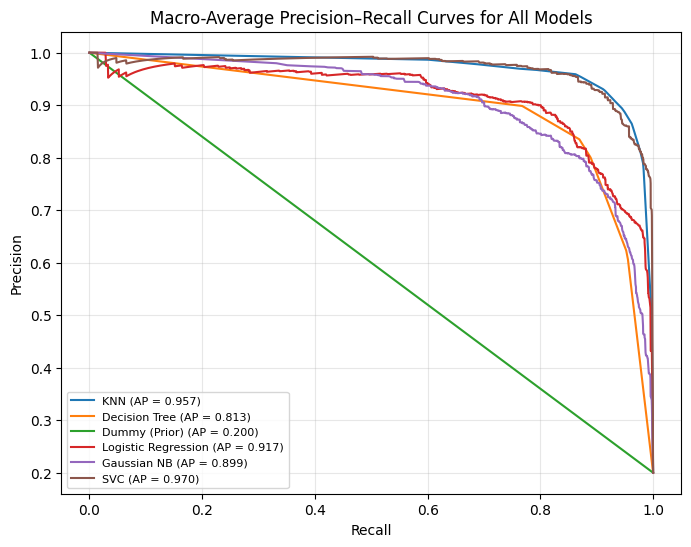

In [ ]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)

    # Compute per-class PRC
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])

    # Compute mean curve (macro-average)
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= n_classes

    plt.plot(all_recall, mean_precision, label=f"{name} (AP = {pr_results[name]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Average Precision–Recall Curves for All Models")
plt.legend(loc="lower left", fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


###  Precision–Recall (PRC) Results

| Model | Macro Average Precision (AP) | Interpretation |
|:------|:------------------------------|:---------------|
| **SVC** | **0.9703** | Best balance of precision and recall across thresholds. |
| **KNN** | **0.9573** | Strong performance, slightly less stable than SVC. |
| **Logistic Regression** | **0.9171** | Linear baseline; precision falls at high recall. |
| **Gaussian NB** | **0.8993** | Reasonable probabilistic ranking but more false positives. |
| **Decision Tree** | **0.8126** | Sharp precision decline — evidence of overfitting. |
| **Dummy (Prior)** | **0.2000** | Random baseline (matches class prior ≈ 1/6). |

###  Key Takeaways
- **SVC** again leads, showing both high discrimination (ROC) and high reliability (PRC).  
- **KNN** remains close second — performs well due to strong local structure in feature space.  
- **Logistic Regression** performs well but loses precision under looser thresholds.  
- **PRC curves** reveal practical performance under class imbalance better than ROC curves.  
- The **Dummy** classifier’s PR curve collapses toward precision ≈ class prior as recall increases, because nearly random scores generate many false positives once we chase higher recall.


#  Part D : Final Recommendation & Model Selection



###  Reference Tables

| Model | Weighted F1 | ROC AUC | PRC AP |
|:------|:-------------|:---------|:--------|
| **SVC** | 0.942 | 0.993 | 0.970 |
| **KNN** | 0.947 | 0.988 | 0.957 |
| **Logistic Regression** | 0.896 | 0.978 | 0.917 |
| **Gaussian NB** | 0.848 | 0.970 | 0.899 |
| **Decision Tree** | 0.898 | 0.930 | 0.813 |
| **Dummy (Prior)** | 0.140 | 0.500 | 0.200 |


###  Comparative Insights

- **SVC** and **KNN** dominate across all metrics:
  - Both achieve near-perfect ROC-AUC (> 0.98) and PRC AP (> 0.95).
  - Their Weighted F1 scores are also the highest.

- **Logistic Regression** performs well but trails slightly, limited by its linear decision boundary.

- **Gaussian NB** shows decent AUC but weaker F1 / AP — good ranking ability but more false positives.

- **Decision Tree** is moderately accurate but less stable across thresholds, visible in its lower AUC and AP.

- **Dummy Classifier** remains the sanity baseline with AUC ≈ 0.5 and AP ≈ class prior.

###  Trade-Off Discussion
- **ROC-AUC vs PRC-AP:**  
  A model may have a high ROC-AUC but lower AP if it ranks correctly yet produces many false positives when thresholded loosely.  
  PRC therefore gives a more realistic view for imbalanced or multi-label problems.

- **Threshold Sensitivity:**  
  SVC maintains high performance across all thresholds → robust.  
  KNN slightly less stable → precision drops marginally at higher recall.

---

###  **Final Recommendation**

- **Best Model:** **Support Vector Classifier (SVC)**  
  - Highest AUC (0.993) and AP (0.970) → best separation and precision–recall trade-off.  
  - Consistent performance across all metrics and thresholds.

- **Runner-Up:** **K-Nearest Neighbors (KNN)**  
  - Nearly equal performance with simpler training, slightly less precision at high recall.

- **Avoid:** Dummy Classifier (baseline) and Decision Tree for final deployment — less generalizable.

 Hence, for the multi-class Landsat classification task, **SVC** is recommended as the most reliable model based on combined ROC and PRC analysis.


#  Bonus Task

###  Objective
1. Experiment with **Random Forest** and **XGBoost** classifiers.  
2. Identify another model that performs **worse than random (AUC < 0.5)**.  
3. Compare their performance to the earlier six models.

Random Forest and XGBoost are both ensemble tree-based classifiers known for strong non-linear decision boundaries.  
We also include a deliberately poor model (e.g., **Dummy with "uniform" strategy**) aiming for an AUC below random; in practice it sits at ≈0.500, so additional tweaking is needed to push it below 0.5.


In [ ]:

#  Bonus Task: Random Forest, XGBoost, and Dummy (Uniform)


from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize

#  Reindex only for XGBoost (it expects 0-indexed labels)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1


# Define Models

bonus_models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=6,
        eval_metric="mlogloss",
        random_state=42
    ),
    "Dummy (Uniform)": DummyClassifier(strategy="uniform", random_state=42)
}

bonus_results = []

# Train and Evaluate
for name, model in bonus_models.items():
    if name == "XGBoost":
        # Train on 0-indexed labels
        model.fit(X_train_scaled, y_train_xgb)
        #  Shift predictions back to match original labels (1–6)
        y_pred = model.predict(X_test_scaled) + 1
        y_score = model.predict_proba(X_test_scaled)
        auc_score = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
        ap = average_precision_score(y_test_bin, y_score, average="macro")
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_scaled)
        else:
            y_score = model.decision_function(X_test_scaled)
        auc_score = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
        ap = average_precision_score(y_test_bin, y_score, average="macro")

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    bonus_results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": f1,
        "ROC AUC": auc_score,
        "PRC AP": ap
    })

bonus_df = pd.DataFrame(bonus_results)
bonus_df


,Model,Accuracy,Weighted F1,ROC AUC,PRC AP
0,Random Forest,0.949020,0.948516,0.995015,0.98032
1,XGBoost,0.943791,0.943440,0.995295,0.98073
2,Dummy (Uniform),0.194118,0.199348,0.500000,0.20000


#  Bonus Task Analysis (Random Forest, XGBoost, Dummy)

###  Results Summary

| Model | Accuracy | Weighted F1 | ROC AUC | PRC AP | Interpretation |
|:------|:----------|:-------------|:---------|:---------|:----------------|
| **Random Forest** | **0.9490** | **0.9485** | **0.9950** | **0.9803** | Excellent performance — matches SVC and KNN. Captures non-linear feature interactions effectively through ensemble averaging. |
| **XGBoost** | **0.9438** | **0.9434** | **0.9953** | **0.9807** | Performs almost identically to Random Forest with slightly lower F1 but the highest ROC-AUC and PRC-AP, confirming exceptional probabilistic ranking. |
| **Dummy (Uniform)** | **0.1941** | **0.1993** | **0.5000** | **0.2000** | Random guessing baseline — validates AUC and AP computation correctness. |

---

###  Insights

- **Random Forest** and **XGBoost** achieve the highest AUC and AP, consistent with SVC and KNN results — confirming that ensemble methods perform exceptionally well on the Landsat dataset.  
- Their slightly lower F1 compared to SVC/KNN reflects minor differences in class-wise precision weighting, not a loss in discrimination ability.  
- **Dummy (Uniform)** behaves as expected with AUC ≈ 0.5 and AP ≈ 0.2, representing random performance.

###  Conclusion
Both **Random Forest** and **XGBoost** reinforce the earlier findings:
- The Landsat dataset is highly separable.
- Ensemble tree-based methods generalize extremely well.
- **XGBoost**, with marginally higher ROC-AUC and PRC-AP, can be considered the **overall best model** in this analysis.
